In [85]:
from matplotlib import image
from matplotlib import pyplot
from sklearn.datasets import load_digits
import numpy as np
import os

In [86]:
import sys
import time

#a function for showing the model's training progress 
def print_percent_done(index, total, error, bar_len=50, title='Please wait'):

    #calculate the percentage that the training is done
    percent_done = index/total*100
    percent_done = round(percent_done, 2)

    #calculate the number of empty and full boxes of progress bar
    done = round(percent_done/(100/bar_len))
    togo = bar_len-done

    done_str = '█'*int(done)
    togo_str = '░'*int(togo)

    #show progress and return to the start of string to rewrite it
    print(f'⏳{title}: [{done_str}{togo_str}] {percent_done}% done, Loss: {error}', end='\r')

    #print checkmark at the start of progress bar and go to the next line
    if percent_done == 100:
        print('✅')


In [87]:
#read the images and the labels
digits = load_digits()
flattened_images = digits.data
targets = digits.target

In [88]:
print("Data shape after flattening:", flattened_images.shape)

#rescale the values in image arrays by dividing them by the maximum value in the arrays
rescaled_images = flattened_images / np.max(flattened_images)
print("Data values range after rescaling: (", np.min(rescaled_images), ",", np.max(rescaled_images), ")")

Data shape after flattening: (1797, 64)
Data values range after rescaling: ( 0.0 , 1.0 )


In [89]:
#calculate labels' onehot encoding using list comprehension
targets_onehot = np.array([[1 if i==j else 0 for j in range(10)] for i in targets])
print("Targets Data shape after onehot encoding: ", targets_onehot.shape)

Targets Data shape after onehot encoding:  (1797, 10)


In [90]:
#combine images and labels arrays to an array of (image, label) tuples
data_tuples = np.array([(rescaled_images[i], targets_onehot[i]) for i in range(rescaled_images.shape[0])], dtype = object)

In [91]:
#a function for generating random minibatches of size "minibatch_size" from tuples, "count" times 
def random_minibatch(tuples, minibatch_size, count):
    rng = np.random.default_rng()

    for i in range(count):
        minibatch = rng.choice(tuples, size = minibatch_size, replace = False)
        yield np.stack(minibatch[:,0]), np.stack(minibatch[:,1])


In [92]:
#a function that gets an array of tuples and a percentage between 0 and 1, randomizes and splits the data to two parts
# based on the percentage, and return an array of tuples as train data, an array of images for test and an array of their labels
def train_test_split(data, train_percentage):
    np.random.shuffle(data)
    data = np.vsplit(data, [int(train_percentage*data.shape[0])])
    return data[0], np.stack(data[1][:,0]), np.stack(data[1][:,1])

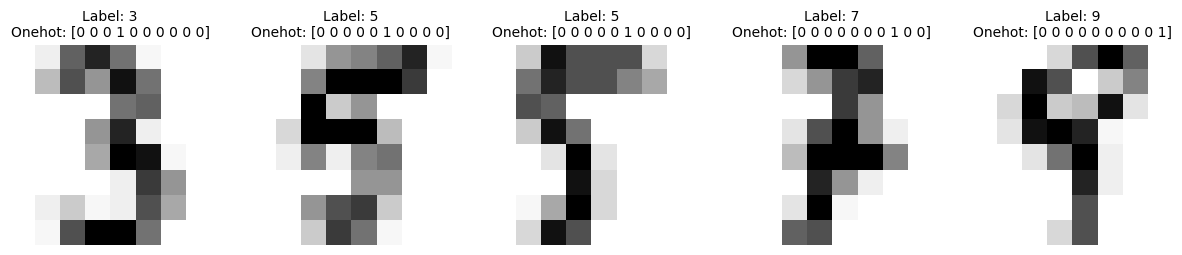

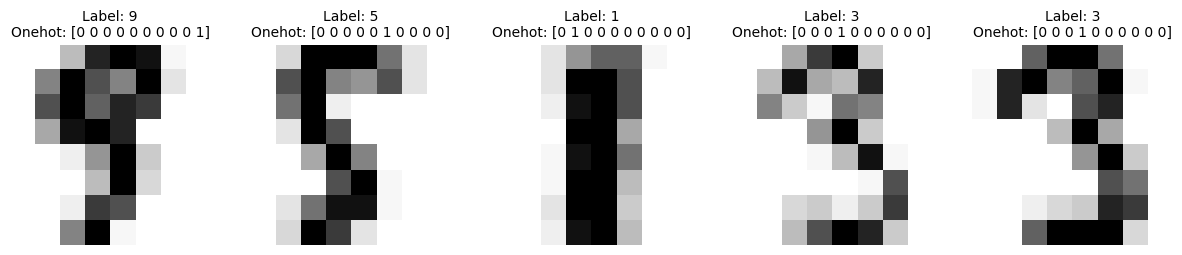

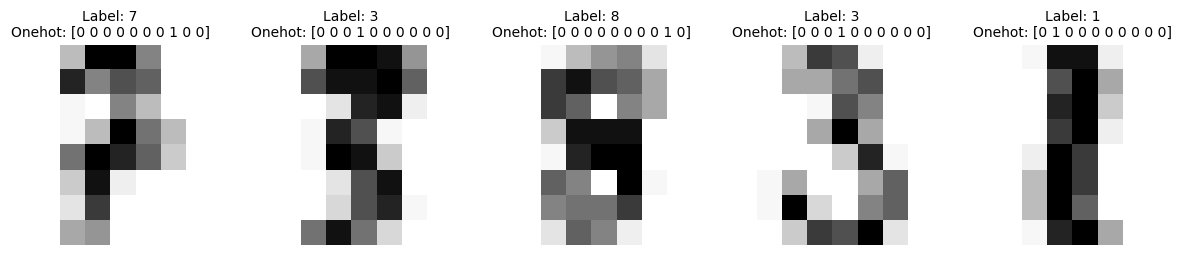

In [93]:
#test random_minibatch function and visualize some random data
sample_count = 3
minibatch_size = 5
for x,y in random_minibatch(data_tuples, minibatch_size, sample_count):
    fig, axs = pyplot.subplots(1, minibatch_size)
    fig.set_size_inches(15,7)
    for i in range(minibatch_size):
        axs[i].imshow(x[i].reshape(8,8), cmap='Greys')
        title = "Label: "+str(np.argmax(y[i]))+"\nOnehot: "+str(y[i])
        axs[i].set_title(title, fontsize = 10) 
        axs[i].axis('off')

In [94]:
class Sigmoid:
    def __init__(self):
        pass

    def call(self, x):
        return 1/(1 + np.exp(-1*x))

    def backward(self, x):
        return self.call(x) * (1 - self.call(x))

In [95]:
class Softmax:
    def __init__(self):
        pass

    def call(self, x):
        return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T

    def backward(self, x):
        n = x.shape[1]
        minibatch_size = x.shape[0]
        #create an array of "minibatch_size" identity matrices 
        eye = np.dstack([np.eye(n)]*minibatch_size)
        #calculate the derivative for every element of minibatch seperately and then stack them together
        return np.stack([(eye - x.T).T[i] * x[i] for i in range(minibatch_size)])

In [96]:
class CategoricalCrossEntropyLoss:
    def __init__(self):
        pass

    def call(self, y, y_pred):
        return -np.sum(y*np.log(y_pred), axis= 1)

    def backward(self, y, y_pred):
        return -y/y_pred


In [97]:
class MLP_Layer:
    def __init__(self, num_units, input_size, activation, learning_rate = 0.1):
        self.weights = np.random.normal(loc=0, scale= 0.2, size=(input_size, num_units))
        self.bias = np.zeros((1, num_units))
        self.activation = activation()
        self.learning_rate = learning_rate

    def forward(self, input):
        d = np.matmul(input, self.weights) + self.bias
        return self.activation.call(d), d

    def backward(self, input, error_signal):
        batch_size = input.shape[0]
        y, y_pre = self.forward(input)
        #since Softmax derivative for minibatches is a 3d array, it can't be handled the same way as other activation functions 
        # and has to be calculated separately for every element of minibatches
        if isinstance(self.activation, Softmax):
            error_signal = np.stack([np.matmul(error_signal[i], self.activation.backward(y)[i]) for i in range(batch_size)])
        else:
            error_signal = error_signal * self.activation.backward(y_pre)
        dw = np.mean([input.T[:,i].reshape((input.shape[1],1)) * error_signal[i,:].reshape((1,error_signal.shape[1])) for i in range(batch_size)], axis = 0)
        db = np.mean(error_signal, axis=0).reshape(self.bias.shape)
        error_signal = np.matmul(error_signal, self.weights.T)
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        return error_signal

In [98]:
class MLP:
    def __init__(self, input_size, layers_size, activations):
        layers_size.insert(0,input_size)
        self.layers = [MLP_Layer(layers_size[i+1], layers_size[i], activations[i]) for i in range(len(layers_size)-1)]

    def forward(self, input):
        y_list = [input]
        for layer in self.layers:
            y, y_pre = layer.forward(y_list[-1])
            y_list.append(y)
        return y_list


    def backward(self, y_list, target):
        batch_size = y_list[0].shape[0]
        y_pred = y_list[-1]
        y_pred = np.clip(y_pred, 1e-7, np.max(y_pred))
        error_signal = CategoricalCrossEntropyLoss().backward(target, y_pred)
        for i in reversed(range(0, len(self.layers))):
            error_signal = self.layers[i].backward(y_list[i], error_signal)
    
    def train(self, data, test_x, test_y, batch_size=5, epoch = 50, iters = 300):
        error_list = []
        for _ in range(epoch):
            i = 0
            for x,y in random_minibatch(data, batch_size, iters):
                i+=1
                y_list = self.forward(x)
                self.backward(y_list, y)
                error = np.mean(CategoricalCrossEntropyLoss().call(y, y_list[-1]))
                print_percent_done(i,iters, round(error,5), title = "Epoch "+ str(_+1))
            y_pred = self.forward(test_x)[-1]
            error_list.append(np.mean(CategoricalCrossEntropyLoss().call(test_y, y_pred)))
        return error_list


✅Epoch 1: [██████████████████████████████████████████████████] 100.0% done, Loss: 1.69523
✅Epoch 2: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.70392
✅Epoch 3: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.3851
✅Epoch 4: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.52264
✅Epoch 5: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.07661
✅Epoch 6: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.08288
✅Epoch 7: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.00436
✅Epoch 8: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.0479
✅Epoch 9: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.03891
✅Epoch 10: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.02174
✅Epoch 11: [██████████████████████████████████████████████████] 100.0% done, Loss: 0.0082
✅Epoch 12: 

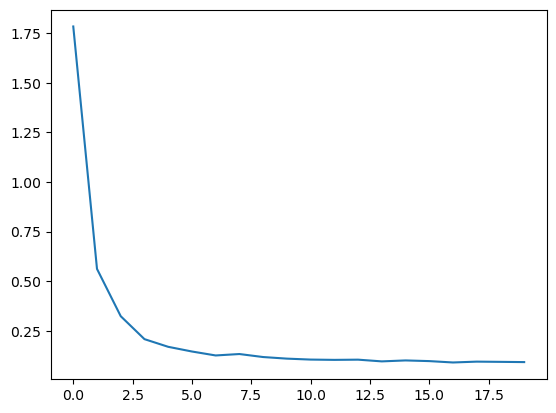

In [99]:
model = MLP(64, [32, 16, 10], [Sigmoid, Sigmoid, Softmax])
data, x_test, y_test = train_test_split(data_tuples, 0.7)
err = model.train(data, x_test, y_test, 5, 20, 1000)
pyplot.plot(err)
pyplot.show()

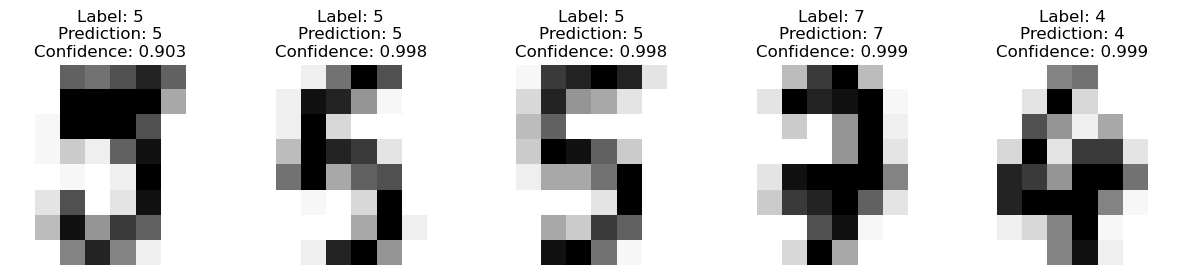

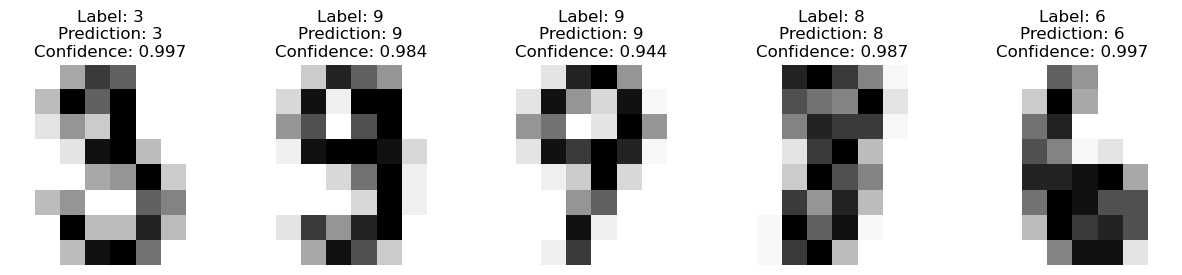

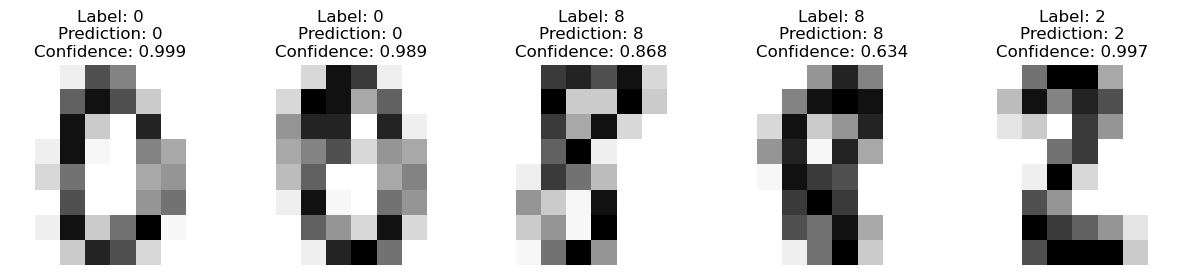

In [100]:
sample_count = 3
minibatch_size = 5
for x,y in random_minibatch(data_tuples, minibatch_size, sample_count):
    fig, axs = pyplot.subplots(1, minibatch_size)
    fig.set_size_inches(15,7)
    for i in range(minibatch_size):
        axs[i].imshow(x[i].reshape(8,8), cmap='Greys')
        pred = model.forward(x)[-1][i]
        title = "Label: "+str(np.argmax(y[i]))+"\nPrediction: "+ str(np.argmax(pred)) + "\nConfidence: " + str(np.round(np.max(pred), 3))
        axs[i].set_title(title, fontsize = 12) 
        axs[i].axis('off')